In [ ]:
# Cargar los datos y obtener el modelo
from common import *
mdl, produccion_vars, products = create_model()
solve_model(mdl, produccion_vars, products)

Model: guia5problematipo2
 - number of variables: 3
   - binary=0, integer=0, continuous=3
 - number of constraints: 9
   - linear=9
 - parameters: defaults
 - objective: none
 - problem type is: LP
* Production model solved with objective: 12800
* Total benefit=12800
Production of A: 0
Production of B: 80.0
Production of C: 320.0


In [ ]:
#***Added by JL - 2024 Mar 03th - Checking sensitivity analysis *****')

# Initialize lists to store the results

#prices = []
#quantities = []

#real_price_value = 0

#m = 0.01


In [ ]:
products

[('A', 50, 100, 0), ('B', 40, 120, 80), ('C', 30, 999999999999999, 0)]

In [ ]:
produccion_vars

{('A', 50, 100, 0): docplex.mp.Var(type=C,name='produccion_A_50_100_0'),
 ('B', 40, 120, 80): docplex.mp.Var(type=C,name='produccion_B_40_120_80'),
 ('C',
  30,
  999999999999999,
  0): docplex.mp.Var(type=C,name='produccion_C_30_999999999999999_0')}

In [ ]:
# Aux: específica de Curva de oferta
# Perform sensitivity analysis of the objective
# Devuelve el lower y upper del rango actual para el coeficiente del funcional
# de la variable prod_var.
def perform_sensitivity_analysis(mdl, prod_var):
    lp = LinearRelaxer.make_relaxed_model(mdl)
    lp.solve()
    cpx = lp.get_engine().get_cplex()
    
    idx=prod_var.index
    ranges = cpx.solution.sensitivity.objective()
    print("[debug] lower, upper:", ranges[idx])

    return ranges[idx]


In [ ]:
# Solves the model for a given price por a product
# price: price to consider
# prod_name: product name ("A", "B", "C")
# prod_number: product number considering their position in the objective (1 = "A", 2 = "B", 3 = "C", ...)
# Al prod_name le pone el price, y resuelve.
def solve_model_for_price(prod_name, price, mdl, products, produccion_vars):

    # Función objetivo
    # Toma los coeficientes de los datos excepto por el de la variable prod_name para la cual considera el coeficiente 'price'
    total_benefit = mdl.sum(produccion_vars[p] * (p[1] if p[0] != prod_name else price) for p in products)
    mdl.maximize(total_benefit)

    solution = mdl.solve()
    if solution is not None:
        print("* Production model solved with objective: {:g}".format(solution.objective_value))
        print("* Total benefit=%g" % solution.objective_value)
        for p in products:
            print("Production of {product}: {prod_var}".format(product=p[0], prod_var=produccion_vars[p].solution_value))

        return solution
    else:
        print("No solution found for price value: {0}".format(price))
        return None  # Return None to indicate that the model is infeasible at this point



In [ ]:
# # Report values for the chart

# def report(price, quantity):
#     prices.append(price)
#     quantities.append(quantity) 
    

In [ ]:
# Get quantity of the product in the solution
### PROBANDO
def get_y(prod_var):
    return prod_var.solution_value

In [ ]:
# aux: mdl, products, produccion_vars, constraint_nameX, constraint_nameY, report_function
       # aux: cant parámetros...
def iterate_left(lower, mdl, products, produccion_vars, constraint_nameX, constraint_nameY, get_y_function):
    x_list = []
    y_list = []
    rhs = lower - LITTLE_M
    while True:
        print("[debug] Viendo para rhs:", rhs)
        if rhs < 0:
            break ## Stop if the rhs is lower than 0                
    
        #solution = solve(c, rhs, mdl, products, produccion_vars)
        solution = solve_model_for_price(constraint_nameX, rhs, mdl, products, produccion_vars)
        if solution is None:
            break  # Stop if the model is infeasible
        else:
            print(f"[debug al append] price: {rhs}, quantity: {get_y_function(constraint_nameY)}")
            store(x_list, y_list, rhs + LITTLE_M, get_y_function(constraint_nameY))
            
        # Perform sensitivity analysis to get the new lower bound
        new_sensitivity = perform_sensitivity_analysis(mdl, constraint_nameY) ###X
        print("[debug] sensitivity", new_sensitivity)            
        # for c_new_sens, (new_lower, _) in zip(mdl.iter_constraints(), new_sensitivity):
        #     if c_new_sens.name == constraint_nameX: 

        (new_lower, _) = new_sensitivity
        rhs = new_lower
        if rhs < 0:
            break ## Stop if the rhs is lower than 0                
            
        solution = solve_model_for_price(constraint_nameX, rhs, mdl, products, produccion_vars)
        if solution is None:
            break  # Stop if the model is infeasible
        store(x_list, y_list, rhs, get_y_function(constraint_nameY))
        
        rhs = new_lower - LITTLE_M #### aux: es para la sgte vuelta del while
    
    return x_list, y_list
    

# aux: mdl, products, produccion_vars, constraint_nameX, constraint_nameY, report_function
       # aux: cant parámetros...
def iterate_right(upper, mdl, products, produccion_vars, constraint_nameX, constraint_nameY, get_y_function):
    x_list = []
    y_list = []
    rhs = upper + LITTLE_M
    ### Aux mientras refactorizo: constraint_nameX y rhs son acá prod_name y price
    
    while True:
        print("[debug] Viendo para rhs:", rhs)
        if rhs >= mdl.infinity:
            break ## Stop if the rhs reaches or exceeds infinity

        solution = solve_model_for_price(constraint_nameX, rhs, mdl, products, produccion_vars)
        if solution is None:
            break  # Stop if the model is infeasible
        else:
            store(x_list, y_list, rhs-LITTLE_M, get_y_function(constraint_nameY))

        # Perform sensitivity analysis to get the new upper bound
        new_sensitivity = perform_sensitivity_analysis(mdl, constraint_nameY) ##X
        # for c_new_sens, (_, new_upper) in zip(mdl.iter_constraints(), new_sensitivity):
        #     if c_new_sens.name == constraint_nameX:
        (_, new_upper) = new_sensitivity
        rhs = new_upper
        if rhs >= mdl.infinity:
            break ## Stop if the rhs reaches or exceeds infinity

        solution = solve_model_for_price(constraint_nameX, rhs, mdl, products, produccion_vars)
        if solution is None:
            break  # Stop if the model is infeasible
        store(x_list, y_list, rhs, get_y_function(constraint_nameY))
        
        rhs = new_upper + LITTLE_M
        
    return x_list, y_list

# aux: ver cantidad de parámetros.
# pre: se resolvió el modelo y existe solución.
#def iterate_over_price_en_construccion(constraint_nameX, constraint_nameY, mdl, products, produccion_vars, get_y_function): # aux: var mdl, 'm', y funciones.
def iterate_over_price_en_construccion(prod_name, prod_var, mdl, products, produccion_vars, get_y_function): # aux: var mdl, 'm', y funciones.
    PRICE_POSITION_IN_PRODUCTS = 1 # price position in products vector (0=name, 1=benefit, 2=max demand, 3=min demand)
    
    # Inicializo listas para acumular los resultados
    prices = []
    quantities = []

    # Obtengo lower y upper iniciales
    initial_lower, initial_upper = perform_sensitivity_analysis(mdl, prod_var)
    print("[debug] (lower, upper):", (initial_lower, initial_upper)) 

    # Obtengo punto actual
    # Buscamos el product_name en el array "products" para consultar en su primera posición su precio
    # (aux: products tiene tuplas, esto obtiene la tupla que tiene 'product_name' como primer valor)
    idx = next((i for i, prod in enumerate(products) if prod[0] == prod_name), None)
    current_price_value = products[idx][PRICE_POSITION_IN_PRODUCTS]
    current_quantity_value = get_y(prod_var)
    print(f"[DEBUG] QUANTITY DE CURRENT_PRICE: {current_quantity_value}")

    # AUX: ACÁ DEBO AGREGAR AL 0, lo agrego desde afuera, al principio de todo

    # Guardo puntos hacia atrás
    #Decrease rhs starting from lower bound - m
    left_x_list, left_y_list = iterate_left(initial_lower, mdl, products, produccion_vars, prod_name, prod_var, get_y_function)
    prices.extend(reversed(left_x_list))
    quantities.extend(reversed(left_y_list))

    # Guardo lower inicial, actual, y upper inicial
    if initial_lower >= 0: ### AUX: agrego este check, xq da -1e20 para curva de oferta
    #if initial_lower > -1*mdl.infinity: ### AUX: agrego este check, xq da -1e20 para curva de oferta        
        store(prices, quantities, initial_lower, current_quantity_value) #aux: puede ser none xq sol infeaseable, pero recién en la sgte vuelta de lower-m (y no aća)
    
    store(prices, quantities, current_price_value, current_quantity_value)
    rhs = initial_upper
    if rhs < mdl.infinity:
        store(prices, quantities, initial_upper, current_quantity_value)
    

    # Guardo puntos hacia adelante
    # Increase rhs starting from upper bound + m
    right_x_list, right_y_list = iterate_right(initial_upper, mdl, products, produccion_vars, prod_name, prod_var, get_y_function)
    prices.extend(right_x_list)
    quantities.extend(right_y_list)
    
    # Devuelvo el current
    
    return current_price_value, prices, quantities

#################################


In [ ]:
# # Iterate over prices (from 0 to infinity) starting from current price value
# # prod_name: product name ("A", "B", "C"), case insentive
# def old__iterate_over_price(prod_name, prod_var):
#     PRICE_POSITION_IN_PRODUCTS = 1 # price position in products vector (0=name, 1=benefit, 2=max demand, 3=min demand)
            
#     # Perform initial sensitivity analysis to get the starting lower and upper bounds
#     lower, upper = perform_sensitivity_analysis(prod_var)
            
#     #Print price 0
#     price = 0 
#     solution = solve_model_for_price(price, prod_name) # Solution nunca valdrá None para Curva de oferta
#     quantity = get_y(prod_var)
#     report(price, quantity)
#     # ********* End of price 0 *********
    
#     #Print real price
#     # Buscamos el product_name en el array "products" para consultar en su primera posición su precio
#     # (aux: products tiene tuplas, esto obtiene la tupla que tiene 'product_name' como primer valor)
#     idx = next((i for i, prod in enumerate(products) if prod[0] == prod_name), None)
#     real_price_value = products[idx][PRICE_POSITION_IN_PRODUCTS]

#     solution = solve_model_for_price(real_price_value, prod_name)
#     quantity = get_y(prod_var)
#     report(real_price_value, quantity)
#     # ********* End of real price *********

#     # *********Store and report the initial lower and upper bounds for the chart*********
#     # Print the lower and upper bounds for price
#     print("---Initial lower bound:", lower)            
#     price = lower            
#     if price >= 0:
#         solution = solve_model_for_price(price, prod_name)
#         quantity = get_y(prod_var)
#         report(price, quantity)
        
#     print("---Initial upper bound:", upper)
#     price = upper
#     # if price <= mdl.infinity:
#     #    solution = solve_model_for_price(price, prod_name)
#     #    if solution is not None:
#     #        quantity = get_y(prod_var)
#     #        if quantity is not None:
#     #            report(price, quantity)            
#     # ********* End of lower and upper bounds *********
                
#     #Decrease price starting from lower bound - m
#     price = lower - m

#     while True:
#         if price < 0:
#             break ## Stop if the price is lower than 0                
    
#         solution = solve_model_for_price(price, prod_name)
#         if solution is None:
#             break  # Stop if the model is infeasible

#         quantity = get_y(prod_var)
#         report(price+m, quantity) #(xq justo antes de entrar al while se le restó m)
            
#         # Perform sensitivity analysis to get the new lower bound
#         new_lower, _ = perform_sensitivity_analysis(prod_var)
        
#         price = new_lower
#         print("NEW LOWER:", new_lower)
#         if price < 0:
#             break ## Stop if the price is lower than 0                
            
#         solution = solve_model_for_price(price, prod_name)
#         if solution is None:
#             break  # Stop if the model is infeasible

#         quantity = get_y(prod_var)
#         if quantity is not None:
#             report(price, quantity)            
                
#         price = new_lower - m
        

#     # Increase price starting from upper bound + m
    
#     return real_price_value
                        

In [ ]:
### PROBANDO
def iterate_over_price_for_var(product_name):
    # esto da, por ejemplo prod_var_or_min_dem_constraint=list(produccion_vars.values())[0] ## "A"
    prod_var = next((value for key, value in produccion_vars.items() if key[0] == product_name), None)
    print(f"prod_var: {prod_var}")
    if prod_var is None:
        raise ValueError(f"ERROR: no se encontró {product_name} en produccion_vars.")
    #return iterate_over_price(product_name, prod_var)

    # Iteramos
    current_price_value, prices, quantities = iterate_over_price_en_construccion(product_name, prod_var, mdl, products, produccion_vars, get_y)
    # Le agregamos el punto de x=0 al inicio, porque la función que itera solo contempla números no negativos    
    price = 0     
    _ = solve_model_for_price(product_name, price, mdl, products, produccion_vars)
    quantity = get_y(prod_var)
    x_values = [price] + prices
    y_values = [quantity] + quantities

    return current_price_value, x_values, y_values




In [ ]:
product_name = "A"
current_price_value, prices, quantities = iterate_over_price_for_var(product_name)
#real_price_value = iterate_over_price(product_name)

prod_var: produccion_A_50_100_0


[debug] lower, upper: (-1e+20, 80.0)
[debug] (lower, upper): (-1e+20, 80.0)
[DEBUG] QUANTITY DE CURRENT_PRICE: 0
[debug] Viendo para rhs: -1e+20
[debug] Viendo para rhs: 80.01
* Production model solved with objective: 12801
* Total benefit=12801
Production of A: 100.0
Production of B: 80.0
Production of C: 53.333333333333314
[debug] lower, upper: (80.00000000000001, 1e+20)
* Production model solved with objective: 12800
* Total benefit=12800
Production of A: 0
Production of B: 80.0
Production of C: 320.0


In [ ]:
print("prices:", prices)
print("quantities:", quantities) 
print("current:", current_price_value) 

# Round all values in the prices list to 2 decimal places    
#prices = [round(price, 2) for price in prices] #

prices: [0, 50, 80.0, 80.0]
quantities: [0, 0, 0, 100.0]
current: 50


In [ ]:
### Aux, probando
round(10.006, 2)
round(10.505, 2) 
#round(10.555, 2)

10.51

In [ ]:
# ### Mejora1
# # Armo pares y los ordeno según 'x'
# pairs = []
# for i in range(len(prices)):
#     pairs.append((prices[i], quantities[i]))

# print("pairs", pairs)

# #pairs.sort()
# # Ordeno ascendentemente por la primera componente y Asc por la segunda si hay empates
# pairs.sort(key=lambda x: (x[0], x[1]))

# print("pairs", pairs)

# # Los vuelvo a separar en listas, para no cambiar la función plot
# new_x, new_y = [], []
# for elem in pairs:
#     new_x.append(elem[0])
#     new_y.append(elem[1])
# print("new_x", new_x)
# print("new_y", new_y)

In [ ]:
def get_text_for_plot(xunit, yunit):
    xlabel='Precio {0}\n{1}'.format(product_name, xunit)
    ylabel='Cantidad\nProducida {0}\n{1}'.format(product_name, yunit)
    title='Curva de Oferta del Producto {}'.format(product_name)

    return {"xlabel": xlabel, "ylabel": ylabel, "title": title}

plt.hline dual_values[i], rhs_values[i], rhs_values[i + 1]: 0 0 50
plt.hline dual_values[i], rhs_values[i], rhs_values[i + 1]: 0 50 80.0
plt.hline dual_values[i], rhs_values[i], rhs_values[i + 1]: 0 80.0 80.0
[debug] current_x_value: 50


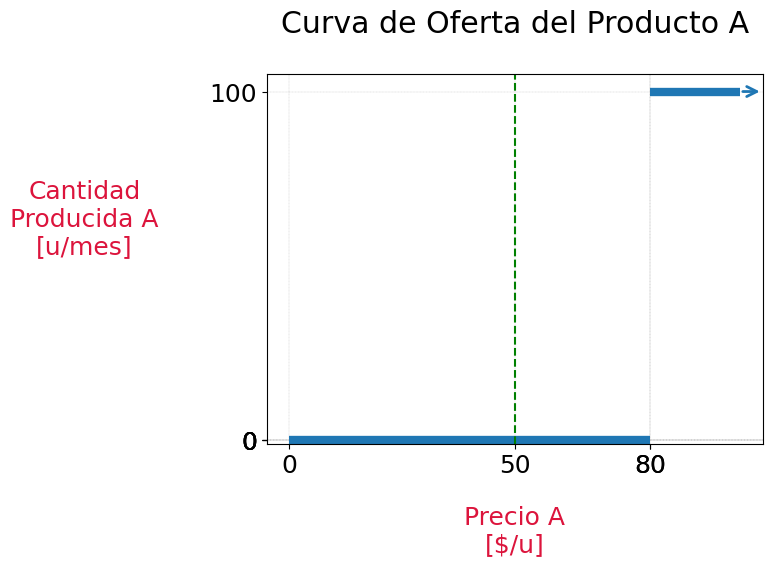

<Figure size 2000x1000 with 0 Axes>

In [ ]:
# Graficar
plot_text = get_text_for_plot("[$/u]", "[u/mes]")
plot(prices, quantities, current_price_value, plot_text)